In [1]:
import pandas as pd
import numpy as np

import os
os.environ['THEANO_FLAGS']='device=cpu'
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time
root = './input/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
# test_df = pd.read_csv(root + 'test.csv')
# weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
print('...loaded')

...loaded
CPU times: user 9.86 s, sys: 1.3 s, total: 11.2 s
Wall time: 10.8 s


In [3]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
# print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of building_meta_df data (1449, 6)


In [4]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train_df = reduce_mem_usage(train_df)
# test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
# weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  4.93 Mb (48.6% reduction)
Mem. usage decreased to  0.03 Mb (52.0% reduction)


In [6]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


 ### Building DF merge through concat

In [7]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
# test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
# weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [8]:
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)
del temp_df, building_meta_df

In [9]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN


### Weather DF merge over concat

In [10]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

In [11]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0


In [12]:
print(train_df.shape)

(20216100, 16)


In [13]:
# find missing values
def find_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_train_data

In [14]:
# drop missing value columns
train_df = train_df.drop(columns=['floor_count'])

In [15]:
# check shape after drop
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0


In [16]:
site_2 = train_df.loc[(train_df['site_id'] == 2) & (train_df['year_built'] > 2005) & (train_df['year_built'] < 2009)]

In [17]:
site_2.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
166,156,0,2016-01-01,114.709999,2,Public services,43681,2007.0,15.6,6.0,-5.6,NaN,1015.299988,270.0,3.6
189,169,0,2016-01-01,468.709991,2,Education,179559,2006.0,15.6,6.0,-5.6,NaN,1015.299988,270.0,3.6
190,169,1,2016-01-01,176.686005,2,Education,179559,2006.0,15.6,6.0,-5.6,NaN,1015.299988,270.0,3.6
191,169,3,2016-01-01,296.002014,2,Education,179559,2006.0,15.6,6.0,-5.6,NaN,1015.299988,270.0,3.6
263,202,0,2016-01-01,143.250000,2,Lodging/residential,74682,2006.0,15.6,6.0,-5.6,NaN,1015.299988,270.0,3.6


In [18]:
site_2['building_id'].value_counts()

209    26308
169    26299
203    26254
202    25896
156     8783
280     8781
Name: building_id, dtype: int64

In [58]:
builds = ['209']
meter = ['0']
builds_selected = train_df.loc[train_df['building_id'].isin(builds)]
builds_selected = builds_selected.loc[builds_selected['meter'].isin(meter)]
#builds_selected.head(20)

In [59]:
builds_selected['year_built'].value_counts()
builds_selected['meter'].value_counts()
#builds_selected['meter'].dtype

0    8772
Name: meter, dtype: int64

In [61]:
find_missing_data(builds_selected)
#builds_selected[builds_selected['meter']==0]
#builds_selected['meter'] = builds_selected['meter'].astype('category')
#builds_selected['primary_use'] = builds_selected['primary_use'].astype('category')
#builds_selected[builds_selected['meter']=='0']
#builds_selected.head(20)

,Total,Percent
cloud_coverage,2355,26.846785
wind_direction,590,6.725946
precip_depth_1_hr,67,0.763794
sea_level_pressure,45,0.512996
wind_speed,6,0.068399
dew_temperature,2,0.022800
air_temperature,2,0.022800
year_built,0,0.000000
square_feet,0,0.000000
primary_use,0,0.000000


In [22]:
#builds_selected.fillna(method='ffill')

In [62]:
df = builds_selected.drop(columns = ['meter','square_feet','timestamp','primary_use','building_id','site_id','cloud_coverage','year_built'])

In [48]:
#builds_selected['meter']

280         0
281         1
282         3
2580        0
2581        1
           ..
20211674    1
20211675    3
20214039    0
20214040    1
20214041    3
Name: meter, Length: 26308, dtype: category
Categories (3, int64): [0, 1, 3]

In [63]:
find_missing_data(df)
#df['wind_direction'].astype('float32')
#df.isin(['wind_direction','precip_depth_1_hr','sea_level_pressure','wind_speed','dew_temperature','air_temperature']).astype('float32')

,Total,Percent
wind_direction,590,6.725946
precip_depth_1_hr,67,0.763794
sea_level_pressure,45,0.512996
wind_speed,6,0.068399
dew_temperature,2,0.022800
air_temperature,2,0.022800
meter_reading,0,0.000000


In [64]:
missing = ['wind_direction','precip_depth_1_hr','sea_level_pressure','wind_speed','dew_temperature','air_temperature']
df1 = df.copy()
df1[missing] = df1[missing].fillna(method = 'ffill')
df1[missing] = df1[missing].fillna(method = 'bfill')

In [65]:
find_missing_data(df1)

,Total,Percent
wind_speed,0,0.0
wind_direction,0,0.0
sea_level_pressure,0,0.0
precip_depth_1_hr,0,0.0
dew_temperature,0,0.0
air_temperature,0,0.0
meter_reading,0,0.0


In [66]:
df1

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
280,893.280029,15.600000,-5.6,0.0,1015.299988,270.0,3.6
2580,920.669983,13.900000,-5.6,0.0,1015.599976,270.0,4.1
4874,921.760010,13.300000,-5.6,0.0,1016.000000,270.0,3.1
7173,920.429993,12.200000,-6.1,0.0,1016.599976,280.0,3.1
9468,922.640015,11.700000,-6.7,0.0,1017.000000,270.0,3.1
...,...,...,...,...,...,...,...
20204579,965.989990,15.000000,11.1,0.0,1012.400024,210.0,3.6
20206942,969.690002,16.100000,10.0,0.0,1011.700012,260.0,3.6
20209308,967.039978,16.700001,9.4,0.0,1011.200012,240.0,4.6
20211673,965.830017,16.700001,10.0,0.0,1011.000000,250.0,3.6


In [135]:
df1.index = np.arange(df1.shape[0])
df1

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,-1.608485,-1.023541,-1.270061,-0.05503,0.732033,1.131077,0.340215
1,-0.971270,-1.210127,-1.270061,-0.05503,0.792833,1.131077,0.594609
2,-0.945911,-1.275980,-1.270061,-0.05503,0.873907,1.131077,0.085821
3,-0.976854,-1.396712,-1.335708,-0.05503,0.995507,1.226820,0.085821
4,-0.925439,-1.451591,-1.414486,-0.05503,1.076581,1.131077,0.085821
...,...,...,...,...,...,...,...
8767,0.083079,-1.089394,0.922582,-0.05503,0.144286,0.556616,0.340215
8768,0.169158,-0.968662,0.778157,-0.05503,0.002412,1.035333,0.340215
8769,0.107506,-0.902809,0.699379,-0.05503,-0.098925,0.843846,0.849002
8770,0.079357,-0.902809,0.778157,-0.05503,-0.139462,0.939590,0.340215


## Fitting a basic linear regression 

In [69]:
df1 = (df1-df1.mean())/df1.std()

In [70]:
predictors =['air_temperature', 'dew_temperature', 'precip_depth_1_hr','sea_level_pressure', 'wind_direction', 'wind_speed']

In [81]:
multiple_model = pm.Model()
with multiple_model:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta', shape=len(predictors))
#    beta_dynamic = pm.Normal('beta_dynamic')
    variance  = pm.InverseGamma('variance', alpha=0.1, beta=0.1)
    sd        = pm.Deterministic('sd', variance**0.5)
    yhat1  = intercept + pm.math.dot(df1[predictors].values, beta)
#    yhat1 = intercept + pm.math.dot(df[predictors],beta) + pm.math.dot(df['timestamp'],beta_dynamic)
    y   = pm.Normal('y', mu=yhat1, sd=sd, observed=df1['meter_reading'].values)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:08<00:00, 244.87draws/s]


In [82]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,0.000133,0.010051,0.000245,-0.020043,0.017657,1631.468496,0.999006
beta__0,-0.159735,0.014346,0.000440,-0.187521,-0.132039,1062.387551,0.999027
beta__1,0.166796,0.011786,0.000349,0.145053,0.189897,1382.382333,1.000975
beta__2,-0.013625,0.010220,0.000265,-0.032235,0.007363,1607.570970,0.999938
beta__3,0.069562,0.013667,0.000457,0.042421,0.095193,918.078197,0.999000
beta__4,-0.115922,0.012213,0.000343,-0.140829,-0.093303,1283.740073,1.001213
beta__5,0.027693,0.011691,0.000339,0.005144,0.051358,1272.676582,1.000343
variance,0.929921,0.014654,0.000362,0.900710,0.957441,1725.872845,0.999529
sd,0.964294,0.007598,0.000188,0.949057,0.978489,1725.608945,0.999529


In [258]:
#pm.forestplot(trace,ylabels=['intercept'] + predictors + ['variance','sd']);

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.plot_posterior(trace,['yhat1'] )

## matrix

In [88]:
multiple_model = pm.Model()
with multiple_model:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta', shape=len(predictors))
#    beta_dynamic = pm.Normal('beta_dynamic')
    variance  = pm.InverseGamma('variance', alpha=0.1, beta=0.1)
    sd        = pm.Deterministic('sd', variance**0.5)
    yhat1  = pm.Deterministic('yhat1',intercept + pm.math.dot(df1[predictors].values, beta))
#    yhat1 = intercept + pm.math.dot(df[predictors],beta) + pm.math.dot(df['timestamp'],beta_dynamic)
    y   = pm.Normal('y', mu=yhat1, sd=sd, observed=df1['meter_reading'].values)
    
    trace3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:12<00:00, 162.07draws/s]


In [73]:
pm.stats.r2_score(df1['meter_reading'].values,trace['yhat1'])

r2_r(r2_median=0.07, r2_mean=0.07, r2_std=0.0)

In [74]:
pm.stats.waic(trace, model = multiple_model)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=24319.835999855466, WAIC_se=1005.490718178229, p_WAIC=61.23063492297363, var_warn=1)

In [101]:
sample_mean = trace3['yhat1'].mean(axis = 0)
p

[-0.1182582  -0.07709614 -0.07510781 ...  0.18060496  0.16570305
  0.1515617 ]


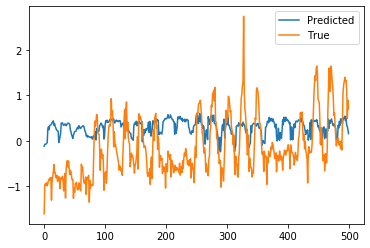

In [104]:
n = 500
plt.plot(sample_mean[0:n],label='Predicted')
plt.plot(df1['meter_reading'].values[0:n],label='True')
plt.legend()

## added weekofday, month, hours as features

In [110]:
builds_selected['timestamp']

280        2016-01-01 00:00:00
2580       2016-01-01 01:00:00
4874       2016-01-01 02:00:00
7173       2016-01-01 03:00:00
9468       2016-01-01 04:00:00
                   ...        
20204579   2016-12-31 19:00:00
20206942   2016-12-31 20:00:00
20209308   2016-12-31 21:00:00
20211673   2016-12-31 22:00:00
20214039   2016-12-31 23:00:00
Name: timestamp, Length: 8772, dtype: datetime64[ns]

In [111]:
dt_index = builds_selected.set_index('timestamp')

In [122]:
month_df = pd.get_dummies(dt_index.index.month,drop_first=True)
month_df.columns = ['month '+str(x) for x in month_df.columns ]
month_df 

,month 2,month 3,month 4,month 5,month 6,month 7,month 8,month 9,month 10,month 11,month 12
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8767,0,0,0,0,0,0,0,0,0,0,1
8768,0,0,0,0,0,0,0,0,0,0,1
8769,0,0,0,0,0,0,0,0,0,0,1
8770,0,0,0,0,0,0,0,0,0,0,1


In [123]:
weekofday =pd.get_dummies(dt_index.index.dayofweek,drop_first=True)
weekofday.columns = ['day '+str(x) for x in weekofday ]
weekofday 

,day 1,day 2,day 3,day 4,day 5,day 6
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
8767,0,0,0,0,1,0
8768,0,0,0,0,1,0
8769,0,0,0,0,1,0
8770,0,0,0,0,1,0


In [137]:
hour =pd.get_dummies(dt_index.index.hour,drop_first=True)
hour.columns = ['hour '+str(x) for x in hour ]
hour 

,hour 1,hour 2,hour 3,hour 4,hour 5,hour 6,hour 7,hour 8,hour 9,hour 10,...,hour 14,hour 15,hour 16,hour 17,hour 18,hour 19,hour 20,hour 21,hour 22,hour 23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [140]:
df_time = pd.concat([month_df, weekofday,hour], axis=1)
df_time
df_final = pd.concat([df1, df_time], axis=1)
df_final

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month 2,month 3,month 4,...,hour 14,hour 15,hour 16,hour 17,hour 18,hour 19,hour 20,hour 21,hour 22,hour 23
0,-1.608485,-1.023541,-1.270061,-0.05503,0.732033,1.131077,0.340215,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.971270,-1.210127,-1.270061,-0.05503,0.792833,1.131077,0.594609,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.945911,-1.275980,-1.270061,-0.05503,0.873907,1.131077,0.085821,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.976854,-1.396712,-1.335708,-0.05503,0.995507,1.226820,0.085821,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.925439,-1.451591,-1.414486,-0.05503,1.076581,1.131077,0.085821,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.083079,-1.089394,0.922582,-0.05503,0.144286,0.556616,0.340215,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8768,0.169158,-0.968662,0.778157,-0.05503,0.002412,1.035333,0.340215,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8769,0.107506,-0.902809,0.699379,-0.05503,-0.098925,0.843846,0.849002,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8770,0.079357,-0.902809,0.778157,-0.05503,-0.139462,0.939590,0.340215,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [144]:
df_final['ts']= np.linspace(-1,1,df.shape[0])
df_final

,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month 2,month 3,month 4,...,hour 15,hour 16,hour 17,hour 18,hour 19,hour 20,hour 21,hour 22,hour 23,ts
0,-1.608485,-1.023541,-1.270061,-0.05503,0.732033,1.131077,0.340215,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.000000
1,-0.971270,-1.210127,-1.270061,-0.05503,0.792833,1.131077,0.594609,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.999772
2,-0.945911,-1.275980,-1.270061,-0.05503,0.873907,1.131077,0.085821,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.999544
3,-0.976854,-1.396712,-1.335708,-0.05503,0.995507,1.226820,0.085821,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.999316
4,-0.925439,-1.451591,-1.414486,-0.05503,1.076581,1.131077,0.085821,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.999088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.083079,-1.089394,0.922582,-0.05503,0.144286,0.556616,0.340215,0,0,0,...,0,0,0,0,1,0,0,0,0,0.999088
8768,0.169158,-0.968662,0.778157,-0.05503,0.002412,1.035333,0.340215,0,0,0,...,0,0,0,0,0,1,0,0,0,0.999316
8769,0.107506,-0.902809,0.699379,-0.05503,-0.098925,0.843846,0.849002,0,0,0,...,0,0,0,0,0,0,1,0,0,0.999544
8770,0.079357,-0.902809,0.778157,-0.05503,-0.139462,0.939590,0.340215,0,0,0,...,0,0,0,0,0,0,0,1,0,0.999772


In [145]:
df_final.columns

Index(['meter_reading', 'air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month 2', 'month 3', 'month 4', 'month 5', 'month 6',
       'month 7', 'month 8', 'month 9', 'month 10', 'month 11', 'month 12',
       'day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'hour 1',
       'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8',
       'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 13', 'hour 14',
       'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20',
       'hour 21', 'hour 22', 'hour 23', 'ts'],
      dtype='object')

In [216]:
df_set = df_final.copy()
df_set = df_set.drop(columns  = ['meter_reading'])

In [217]:
train = df_set.iloc[:6000]
test = df_set.iloc[6000:]

In [218]:
df_final.shape

(8772, 48)

In [219]:
train.shape
x_shared.shape

Shape.0

In [220]:
train.shape

(6000, 47)

In [221]:
df_set.columns

Index(['air_temperature', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'month 2',
       'month 3', 'month 4', 'month 5', 'month 6', 'month 7', 'month 8',
       'month 9', 'month 10', 'month 11', 'month 12', 'day 1', 'day 2',
       'day 3', 'day 4', 'day 5', 'day 6', 'hour 1', 'hour 2', 'hour 3',
       'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10',
       'hour 11', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16',
       'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22',
       'hour 23', 'ts'],
      dtype='object')

In [225]:
import theano
x_shared = theano.shared(train.values)
y_shared = theano.shared(df_final['meter_reading'][:6000].values)

In [226]:
predictors_time = ['air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month 2', 'month 3', 'month 4', 'month 5', 'month 6',
       'month 7', 'month 8', 'month 9', 'month 10', 'month 11', 'month 12',
       'day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'hour 1',
       'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8',
       'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 13', 'hour 14',
       'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20',
       'hour 21', 'hour 22', 'hour 23', 'ts']

In [227]:
multiple_model_time = pm.Model()
with multiple_model_time:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta', shape=len(predictors_time))
#    beta_dynamic = pm.Normal('beta_dynamic')
    variance  = pm.InverseGamma('variance', alpha=0.1, beta=0.1)
    sd        = pm.Deterministic('sd', variance**0.5)
    yhat1  = pm.Deterministic('yhat1',intercept + pm.math.dot(x_shared, beta))
    y   = pm.Normal('y', mu=yhat1, sd=sd, observed=y_shared)
    
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:27<00:00, 22.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [264]:
pm.summary(trace1,varnames=['beta','intercept','sd'])

/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-0.020686,0.035817,0.001592,-0.089550,0.050057,446.546281,1.000205
beta__1,0.006964,0.018201,0.000582,-0.025961,0.043675,876.686758,1.000028
beta__2,0.002717,0.010451,0.000286,-0.017209,0.022813,1020.341269,0.999468
beta__3,0.082518,0.018080,0.000594,0.048287,0.118359,907.362175,0.999908
beta__4,-0.002396,0.013828,0.000400,-0.028872,0.027320,1127.760139,0.999660
beta__5,0.005444,0.012553,0.000392,-0.018196,0.030847,1109.426838,0.999050
beta__6,-0.248322,0.059368,0.002626,-0.367993,-0.130483,348.732906,0.999204
beta__7,-0.565427,0.081308,0.004239,-0.717266,-0.399774,242.209635,0.999628
beta__8,0.042803,0.110726,0.006193,-0.200435,0.242046,207.748752,0.999838
beta__9,-0.817293,0.139795,0.007935,-1.085293,-0.542728,198.286147,1.000551


In [233]:
test.shape

(2772, 47)

In [234]:
df_final['meter_reading'][6000:].shape

(2772,)

In [237]:
x_shared.set_value(test.values)
y_shared.set_value(df_final['meter_reading'][6000:].values) 

with multiple_model_time:
    post_pred = pm.sample_posterior_predictive(trace1, samples=1000)

100%|██████████| 1000/1000 [00:16<00:00, 59.51it/s]


In [245]:
y_pred=post_pred['y'].mean(axis = 0)

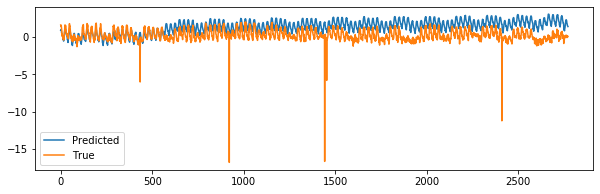

In [246]:
#n = 1000
plt.figure(figsize=(10,3))
plt.plot(y_pred,label='Predicted')
plt.plot(df_final['meter_reading'].values[6000:],label='True')
plt.legend()

In [154]:
sample_mean_time = trace1['yhat1'].mean(axis = 0)
print(sample_mean_time)

[-0.39265635 -0.55629079 -0.50025334 ... -0.35142572 -0.35475421
 -0.38880739]


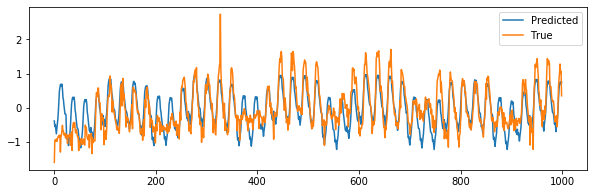

In [159]:
n = 1000
plt.figure(figsize=(10,3))
plt.plot(sample_mean_time[0:n],label='Predicted')
plt.plot(df_final['meter_reading'].values[0:n],label='True')
plt.legend()

In [260]:
pm.stats.waic(trace1, model = multiple_model_time)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=39257.51825200213, WAIC_se=2665.82490024812, p_WAIC=14714.607909200678, var_warn=1)

In [263]:
pm.stats.r2_score(df1['meter_reading'].values,trace1['yhat1'])

r2_r(r2_median=0.33, r2_mean=0.33, r2_std=0.0)

In [275]:
pm.stats.r2_score(df_final['meter_reading'].values[:6000],trace1['yhat1'])

r2_r(r2_median=0.33, r2_mean=0.33, r2_std=0.0)

## Model with AR1

In [247]:
with pm.Model() as correlated_error_model:
    intercept  = pm.Normal('intercept')
    beta      = pm.Normal('beta',shape=len(predictors_time))    
    
    tau      = pm.Gamma('tau',0.1,0.1)
    sd = pm.Deterministic('sd',(1 / tau)**0.5)
    k        = pm.Uniform('k')
    mu      = pm.Deterministic('mu',intercept + pm.math.dot(x_shared,beta))
    data    = pm.AR1('data', k=k, tau_e=tau, observed=y_shared-mu)
    
    trace4 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, tau, beta, intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:41<00:00, 18.55draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [250]:
x_shared.set_value(test.values)
y_shared.set_value(df_final['meter_reading'][6000:].values) 

with correlated_error_model:
    post_pred1 = pm.sample_posterior_predictive(trace4, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1557.29it/s]


In [256]:
y_pred=post_pred['data'].mean(axis = 0)

In [255]:
post_pred1.keys()

dict_keys(['data'])

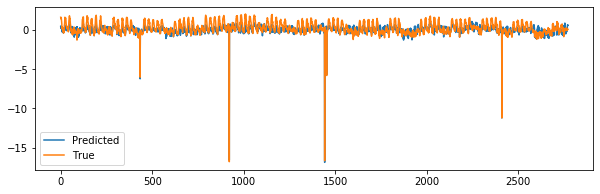

In [257]:
plt.figure(figsize=(10,3))
plt.plot(y_pred,label='Predicted')
plt.plot(df_final['meter_reading'].values[6000:],label='True')
plt.legend()

In [180]:
pm.summary(trace4,varnames=['beta','intercept','k','sd'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,0.020381,0.040708,0.001992,-0.054868,0.102313,405.089079,0.999170
beta__1,0.021971,0.022688,0.000701,-0.018904,0.067793,965.142502,0.999164
beta__2,0.003439,0.006750,0.000179,-0.008938,0.017040,1657.384159,1.000384
beta__3,0.071131,0.023045,0.000801,0.023064,0.112287,827.408796,0.999056
beta__4,-0.000265,0.010126,0.000347,-0.018316,0.020438,912.069010,0.999095
beta__5,-0.001387,0.010834,0.000337,-0.021447,0.019291,1005.198069,0.999001
beta__6,-0.154370,0.080258,0.003348,-0.310791,0.002270,504.365910,1.000408
beta__7,-0.375088,0.098528,0.005123,-0.554266,-0.192301,329.198333,1.003654
beta__8,0.324381,0.117721,0.006945,0.093555,0.528572,260.046989,1.002539
beta__9,-0.440237,0.146240,0.008853,-0.717782,-0.161934,236.232561,1.004339


In [181]:
sample_mean_time1 = trace4['mu'].mean(axis = 0)
print(sample_mean_time1)

[-0.40542649 -0.55767655 -0.56727223 ... -0.32722671 -0.31838051
 -0.34566262]


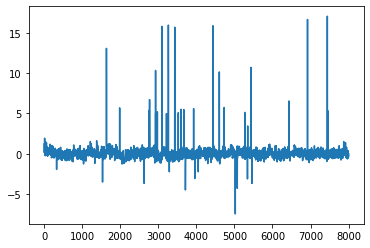

In [182]:
n=8000
residuals = trace4['mu'].mean(axis = 0)[0:n] - df_final['meter_reading'].values[0:n] 
plt.plot(residuals)

In [183]:
np.min(df_final['meter_reading'].values)

-17.02962

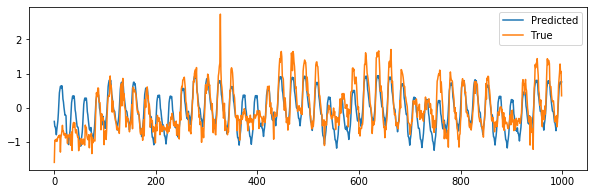

In [184]:
n = 1000
plt.figure(figsize=(10,3))
plt.plot(sample_mean_time1[0:n],label='Predicted')
plt.plot(df_final['meter_reading'].values[0:n],label='True')
plt.legend()

In [270]:
pm.stats.r2_score(df_final['meter_reading'].values[6000:],trace4['mu'])

r2_r(r2_median=0.4, r2_mean=0.4, r2_std=0.0)

In [268]:
pm.stats.waic(trace4, model = correlated_error_model)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=5222.8665803808735, WAIC_se=0.0, p_WAIC=20.133894948017083, var_warn=1)

In [279]:
pm.forestplot(trace4,ylabels=['intercept'] + predictors + ['sd']);

ImportError: ArviZ is not installed. In order to use `plot_forest`:
pip install arviz

In [ ]:
pm.plot_posterior(trace4,['mu'] )

In [ ]:
pm.traceplot(trace4)

## matrix

In [77]:
with pm.Model() as correlated_error_model:
    intercept  = pm.Normal('intercept')
    beta      = pm.Normal('beta',shape=len(predictors))
    variance  = pm.InverseGamma('variance',alpha=0.1,beta=0.1)
    sd        = pm.Deterministic('sd',variance**0.5)
    
    tau      = pm.Gamma('tau',0.1,0.1)
    k        = pm.Uniform('k')
    data    = pm.AR1('data', k=k, tau_e=tau, observed=(df1['meter_reading']))
    mu      = pm.Deterministic('mu',intercept + pm.math.dot(df1[predictors],beta) + data)
    y   = pm.Normal('y', mu=mu, sd=sd, observed=df1['meter_reading'])
    
    trace4 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, tau, variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [01:12<00:00, 41.33draws/s] 


In [78]:
pm.stats.r2_score(df1['meter_reading'].values,trace4['mu'])

r2_r(r2_median=1.0, r2_mean=1.0, r2_std=0.0)

In [79]:
pm.stats.waic(trace4, model = correlated_error_model)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-58089.209398045394, WAIC_se=19542.135442296665, p_WAIC=1.697907278988956, var_warn=1)

## the exucation of rest part is not able to finish. It takes forever to run

In [ ]:
pm.forestplot(trace4,ylabels=['intercept'] + predictors + ['variance','sd'] + ['beta_dynamic']);

In [ ]:
pm.plot_posterior(trace4,['mu'] )

In [ ]:
pm.traceplot(trace4)

## Draft

In [ ]:
with pm.Model() as correlated_error_model:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta',shape=len(predictors))
    mu       = intercept + pm.math.dot(df1[predictors], beta)
    tau      = pm.Gamma('tau',0.1,0.1)
    k        = pm.Uniform('k')
    print(predictors)
    print(df1['meter_reading']-mu)
#    error    = pm.AR1('error', k=k, tau_e=tau, observed=(df1['meter_reading']-mu).T)
    
#    yhat1 = intercept + pm.math.dot(df1[predictors],beta) + pm.math.dot(df1['meter_reading'],beta_dynamic)
#     trace4 = pm.sample(tune=1000)